In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.integrate as sp

# How to solve

Urea thing:
1. run solve_svp to ~lifetime of reaction to get equilibrium for each one
2. solve_svp returns the solutions at a given end time and at intermediate times, chooses the timestep by itself also so takes no input

Oregonator:
1. Can run solve_svp again to follow the reaction, plus it returns concentrations at timesteps

Also:
1. Create a program to run an integrator by itself
2. Either Euler solver or BDF from first principles, difficulty in variable timestepper creation, need to make one that uses larger timesteps then reduces if a given change is negative

In [2]:
# set initial rate constants
ku_15_0 = 6.0e-2
ku_16_0 = 7.5e-4
kf_15_0 = 26000.0
kf_16_0 = 730.0 

def k_convert(k,u,const):
    return k*np.exp(const*u)

In [208]:
# Cell of system class
class Cell:
    '''
    '''

    def __init__(self,dconc,iconc,nconc,urea):
        # Create a cell instance and rate constants
        self.dconc = dconc
        self.iconc = iconc
        self.nconc = nconc
        self.urea = urea
        
        self.kf_15 = k_convert(kf_15_0,urea,-1.68)
        self.ku_15 = k_convert(ku_15_0,urea,0.95)
        self.kf_16 = k_convert(kf_16_0,urea,-1.72)
        self.ku_16 = k_convert(ku_16_0,urea,1.20)
    
    def dXdt(self,t,din):
        # Determine rates of change of each species (ONLY FOR SCIPY SOLUTION)
        d,i,n = din
        dDdt = self.ku_15 * i - self.kf_15 * d
        dIdt = self.kf_15 * d + self.ku_16 * n - self.kf_16 * i - self.ku_15 * i
        dNdt = self.kf_16 * i - self.ku_16 * n
        return dDdt,dIdt,dNdt
    
    def dX(self):
        # Differential equations to be solved
        dDdt = (self.ku_15*self.iconc)-(self.kf_15*self.dconc)
        dIdt = (self.kf_15*self.dconc)+(self.ku_16*self.nconc)-(self.kf_16*self.iconc)-(self.ku_15*self.iconc)
        dNdt = (self.kf_16*self.iconc)-(self.ku_16*self.nconc)
        return dDdt,dIdt,dNdt
    
    def timestep(self,step):
        dD,dI,dN = self.dX()
        nxtd = self.dconc + step*dD
        nxti = self.iconc + step*dI
        nxtn = self.nconc + step*dN
        
        return nxtd,nxti,nxtn

    def equilibrium(self,initstep,rtol,atol): #rtol
        # conv = False
        time = 0
        step = initstep
        reldelta = np.array([100,100,100])
        absdelta = np.array([100,100,100])

        while any([np.abs(reldiff) > rtol for reldiff in reldelta]) and any([np.abs(absdiff) > atol for absdiff in absdelta]):
            
            nxtd,nxti,nxtn = self.timestep(step)

            reldelta = np.array([(self.dconc-nxtd)/nxtd,(self.iconc-nxti)/nxti,(self.nconc-nxtn)/nxtn])
            absdelta = np.array([self.dconc-nxtd,self.iconc-nxti,self.nconc-nxtn])

            # Progress concentrations
            self.dconc = nxtd
            self.iconc = nxti
            self.nconc = nxtn
            time += step
    
        print('urea='+str(self.urea)+' converged in '+str(time)+'s simulated')

    # def find_equil(self,initstep,steptol,tf):
    #     # Find the equilibrium of the system contained within the class
    #     conv = False
    #     time = 0
    #     step = initstep
    #     safe_factor = 0.7

    #     while time<tf:
            
    #         nxtd,nxti,nxtn = self.timestep(step)

    #         # Determine error and compare to tolerance

    #         d_err = np.abs(nxtd-self.dconc)
    #         i_err = np.abs(nxti-self.iconc) 
    #         n_err = np.abs(nxtn-self.nconc)
    #         error = list([d_err,i_err,n_err])

    #         # if max(d_err,i_err,n_err) == d_err:
    #         #     scale_tol = steptol * max(self.dconc,nxtd)
    #         # elif max(d_err,i_err,n_err) == i_err:
    #         #     scale_tol = steptol * max(self.iconc,nxti)
    #         # else:
    #         #     scale_tol = steptol * max(self.nconc,nxtn)

    #         # set values and increase step if within error, otherwise decrease
    #         if error/steptol <=1:
    #             # DLast = self.dconc
    #             # ILast = self.iconc
    #             # NLast = self.nconc

    #             self.dconc = nxtd
    #             self.iconc = nxti
    #             self.nconc = nxtn
    #             time += step

    #             # # Check for convergence if step made
    #             # if np.allclose(self.dconc,DLast,rtol=rtol,atol=atol) and\
    #             #     np.allclose(self.iconc,ILast,rtol=rtol,atol=atol) and\
    #             #     np.allclose(self.nconc,NLast,rtol=rtol,atol=atol):

    #             #     print('urea='+str(self.urea)+' converged in '+str(time)+'s simulated')
    #             #     conv = True


    #             step *= safe_factor * np.power(scale_tol/total_err,0.5)
    #         else:
    #             # change step size down if error too high
    #             step *= safe_factor * np.power(scale_tol/total_err,1/3)
            



### Equilibria from own integrator

In [212]:
# Solve a range of 100 equilibriums using Euler integrator, takes ~9.5mins
rxns = list()
ur = np.linspace(0,8,100)

d_eq = np.array([0])
i_eq = np.array([0])
n_eq = np.array([1])

for u in ur:
    rxns.append(Cell(d_eq[-1],i_eq[-1],n_eq[-1],u))
    rxns[-1].equilibrium(1e-5,1e-7,1e-7)
    d_eq = np.append(d_eq,rxns[-1].dconc)
    i_eq = np.append(i_eq,rxns[-1].iconc)
    n_eq = np.append(n_eq,rxns[-1].nconc)

d_eq = np.delete(d_eq,0)
i_eq = np.delete(i_eq,0)
n_eq = np.delete(n_eq,0)

urea=0.0 converged in 1e-05s simulated
urea=0.08080808080808081 converged in 1e-05s simulated
urea=0.16161616161616163 converged in 1e-05s simulated
urea=0.24242424242424243 converged in 1e-05s simulated
urea=0.32323232323232326 converged in 1e-05s simulated
urea=0.4040404040404041 converged in 1e-05s simulated
urea=0.48484848484848486 converged in 1e-05s simulated
urea=0.5656565656565657 converged in 1e-05s simulated
urea=0.6464646464646465 converged in 1e-05s simulated
urea=0.7272727272727273 converged in 1e-05s simulated
urea=0.8080808080808082 converged in 1e-05s simulated
urea=0.888888888888889 converged in 1e-05s simulated
urea=0.9696969696969697 converged in 1e-05s simulated
urea=1.0505050505050506 converged in 1e-05s simulated
urea=1.1313131313131315 converged in 1e-05s simulated
urea=1.2121212121212122 converged in 1e-05s simulated
urea=1.292929292929293 converged in 1e-05s simulated
urea=1.373737373737374 converged in 1e-05s simulated
urea=1.4545454545454546 converged in 1e-0

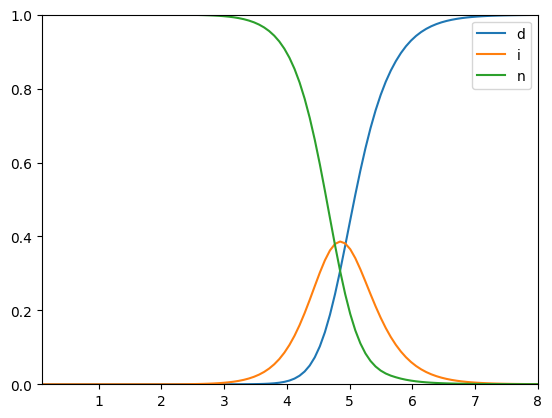

In [213]:
# Plot equilibrium values obtained
fig = plt.figure()
ax = plt.axes()

ax.plot(ur,d_eq,label='d')
ax.plot(ur,i_eq,label='i')
ax.plot(ur,n_eq,label='n')

ax.set_xlim(0.09,8)
ax.set_ylim(0,1)

plt.legend()

### Finding equilibria with scipy

In [214]:
# Solve a range of 100 equilibriums using the scipy package
rxns = list()
ur = np.linspace(0,8,1000)

for u in ur:
    rxns.append(Cell(0,0,1,u))

d_eq = np.empty(0)
i_eq = np.empty(0)
n_eq = np.empty(0)

for r in rxns:
    y0 = [r.dconc,r.iconc,r.nconc]
    sol = sp.solve_ivp(r.dXdt,(0,20),y0,method='BDF',t_eval=[20])
    d_eq = np.append(d_eq,sol.y[0])
    i_eq = np.append(i_eq,sol.y[1])
    n_eq = np.append(n_eq,sol.y[2])

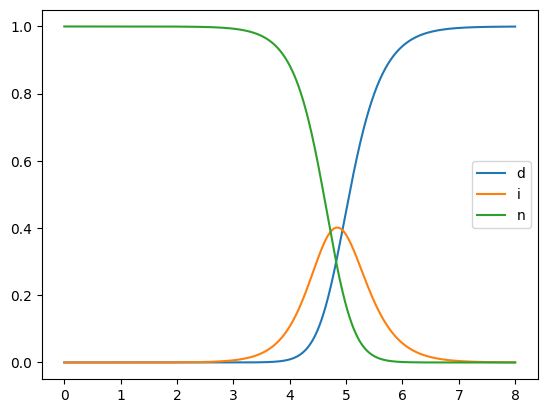

In [215]:
# Plot equilibrium values obtained with sp.solve_ivp()
fig = plt.figure()
ax = plt.axes()

ax.plot(ur,d_eq,label='d')
ax.plot(ur,i_eq,label='i')
ax.plot(ur,n_eq,label='n')

plt.legend()